# Import all necessary libraries

In [11]:
!pip install pyitlib

  Created wheel for pyitlib: filename=pyitlib-0.2.2-cp36-none-any.whl size=28503 sha256=b3789da30572425b7402f19bca38de53060735010e9df389d6c7658224a70dd7
  Stored in directory: /root/.cache/pip/wheels/1c/f8/41/f4b4e777dd6ea714f2c4900367fb479e9fca0eb000c46e73f3
Successfully built pyitlib


In [12]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from google.colab import files
import math
import itertools

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from pyitlib import discrete_random_variable as drv

# Functions and data

### Functions

In [13]:
def importFile(filename):
  datafile = csv.reader(open(filename,'r'))
  data = []
  label = []

  for idx, row in enumerate(datafile):
    data.append(row[:-1])
    label.append(float(row[-1]))
  
  for idx, row in enumerate(data):
    data[idx] = [float(ele) for ele in row]

  return np.array(data), np.array(label)

def cndtEntropy(feature,label,printNum):
  featureValue = np.unique(feature)
  infoEntropyFeature = []

  for i in featureValue:
    index = np.where(feature==i)[0]

    labelI = label[index]

    malignantNum = len(np.where(labelI==4)[0])
    benignNum = len(np.where(labelI==2)[0])
    totalNum = malignantNum + benignNum
    if totalNum != len(index):
      print("Wrong calculation!")

    if printNum == True:
      print("Malignant number: {}".format(malignantNum))
      print("Benign number: {}".format(benignNum))
      print("=========================")
      
    if malignantNum == 0 or benignNum == 0:
      infoEntropy = 0
    else:
      infoEntropy = -((malignantNum/totalNum)*math.log2(malignantNum/totalNum) + 
                    (benignNum/totalNum)*math.log2(benignNum/totalNum))
    
    infoEntropyFeature.append([infoEntropy,totalNum])
  
  infoEntropyFeature = np.array(infoEntropyFeature)
  infoEntropyFeature[:,1] = infoEntropyFeature[:,1]/len(feature)
  if printNum == True:
    print(infoEntropyFeature)
    print(np.sum(infoEntropyFeature[:,1]))
  
  conditionEntropy = np.matmul(infoEntropyFeature[:,0],infoEntropyFeature[:,1])

  return conditionEntropy

def setdiff_nd_positivenums(a,b):
    s = np.maximum(a.max(0)+1,b.max(0)+1)
    return a[~np.isin(a.dot(s),b.dot(s))]

def splitData(data,label,i):
  n = data.shape[0]
  groupSize = int(np.floor(n/5))

  val = data[groupSize*i:(groupSize*(i+1)+3),:]
  labelVal = label[groupSize*i:groupSize*(i+1)+3]

  # train = np.array([line for line in data if line not in val])
  # labelTrain = np.array([line for line in label if line not in labelVal])
  train = np.concatenate((data[0:groupSize*i,:],data[groupSize*(i+1)+3:,:]),axis=0)
  labelTrain = np.concatenate((label[0:groupSize*i],label[groupSize*(i+1)+3:]),axis=0)

  return train, labelTrain, val, labelVal


### Data

In [14]:
data, label = importFile('hw4_train.csv')
dataTest, labelTest = importFile('hw4_test.csv')
# print(data.shape[1])
# print(dataTest.shape)

# Histogram

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

401



202


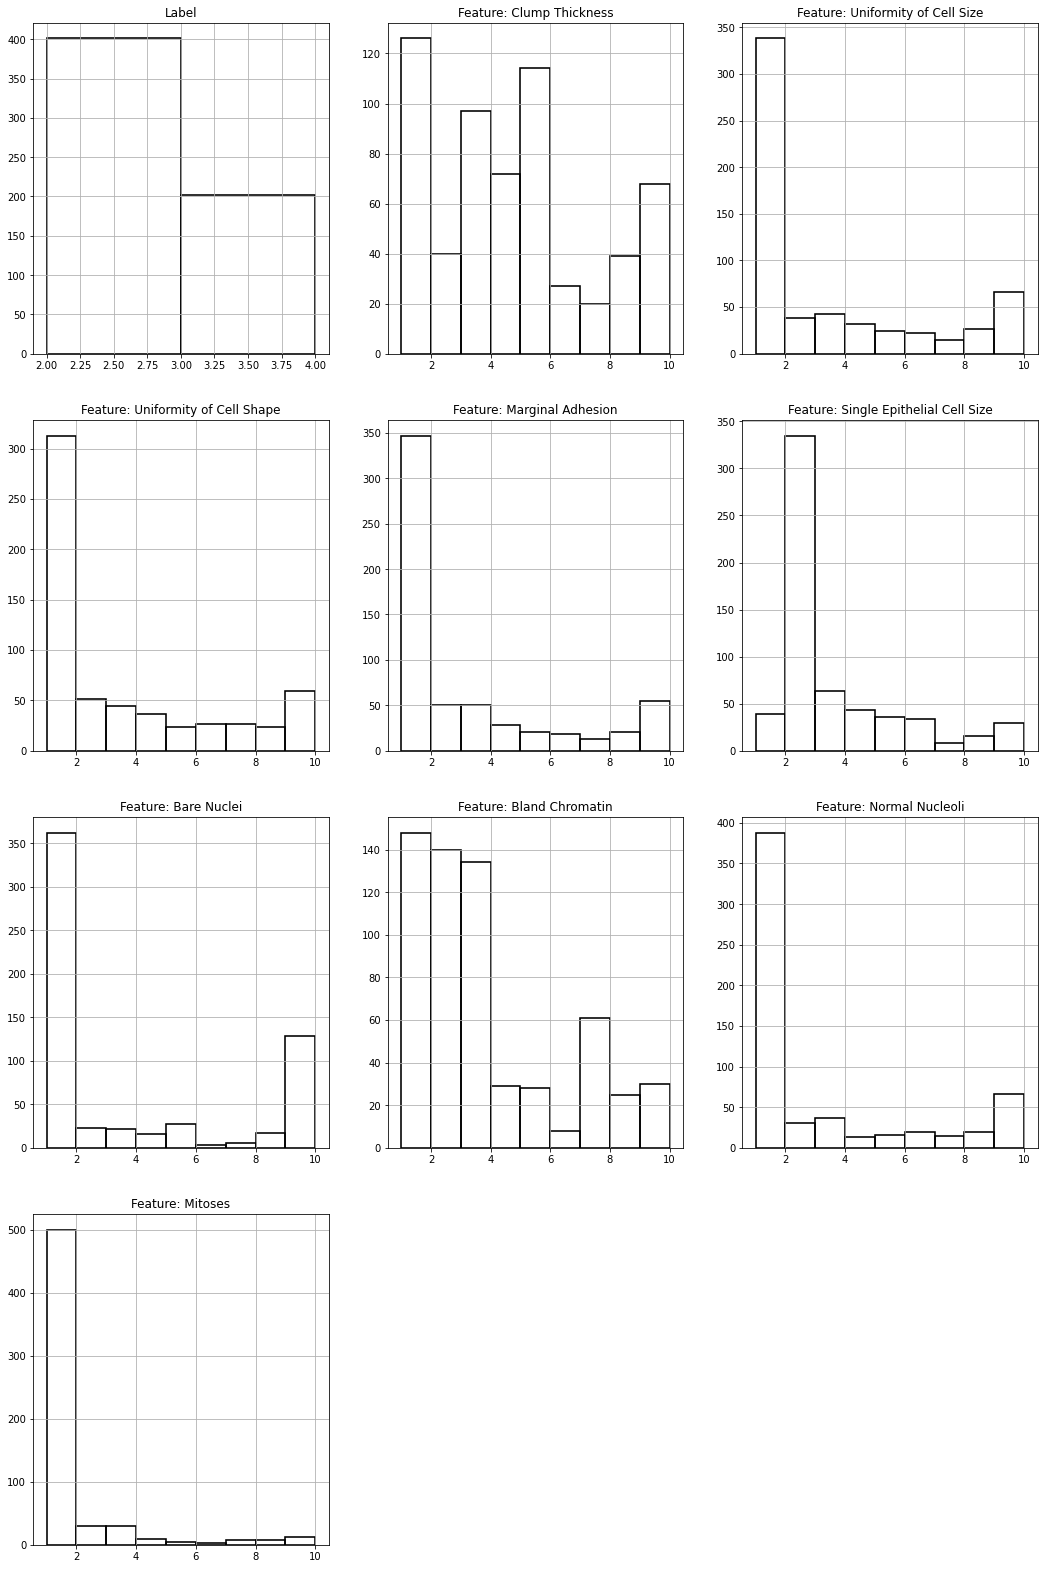

In [ ]:
features = ['Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion',
            'Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli',
            'Mitoses']
plt.figure(figsize=(3*6,4*7))
for i in range(data.shape[1]+1):
  plt.subplot(4,3,i+1)
  if i == 0:
    plt.hist(label,bins=2,range=[2,4],fill=False,linewidth=1.6)
    plt.title('Label')
  else:
    plt.hist(data[:,i-1],bins=range(1,11,1),fill=False,width=1,linewidth=1.61)
    plt.title('Feature: '+features[i-1])
  plt.grid(axis='both')
plt.savefig("Histogram.png",dpi=160)
files.download("Histogram.png")

benign = len(np.where(label==2)[0])
malignant = len(np.where(label==4)[0])

print(benign)
print("\n\n")
print(malignant)
  

# Conditional Entropy

In [15]:
entropy = cndtEntropy(data[:,0],label,True)
# print(entropy)

features = ['Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion',
            'Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli',
            'Mitoses']
for i in range(data.shape[1]):
  entropy = cndtEntropy(data[:,i],label,False)
  print("Feature " + features[i] + " entropy is: {}".format(entropy))

Malignant number: 3
Benign number: 123
Malignant number: 3
Benign number: 37
Malignant number: 11
Benign number: 86
Malignant number: 12
Benign number: 60
Malignant number: 36
Benign number: 78
Malignant number: 15
Benign number: 12
Malignant number: 19
Benign number: 1
Malignant number: 35
Benign number: 4
Malignant number: 10
Benign number: 0
Malignant number: 58
Benign number: 0
[[0.16232618 0.20895522]
 [0.38431154 0.06633499]
 [0.51009308 0.16086235]
 [0.65002242 0.11940299]
 [0.89974376 0.18905473]
 [0.99107606 0.04477612]
 [0.28639696 0.0331675 ]
 [0.47707131 0.06467662]
 [0.         0.01658375]
 [0.         0.09618574]]
1.0
Feature Clump Thickness entropy is: 0.47391337645225295
Feature Uniformity of Cell Size entropy is: 0.21066883738334902
Feature Uniformity of Cell Shape entropy is: 0.23381960613391514
Feature Marginal Adhesion entropy is: 0.4243215691640549
Feature Single Epithelial Cell Size entropy is: 0.38291093098911816
Feature Bare Nuclei entropy is: 0.2754898472623088

# Decision trees and random forest

### Randomly shuffle data

In [ ]:
np.random.seed(0)
index = np.random.permutation(data.shape[0])

cvData = data[index]
cvLabel = label[index]

# cvTrain, cvTrainLabel, cvVal, cvValLabel = splitData(cvData,cvLabel,0)
# print(cvVal)
# # del sum
# print(sum(cvData[:,0]))

# print(sum(cvTrain[:,0])+sum(cvVal[:,0]))



### Decision tree

In [ ]:
bestDepth = 1
accPrev = 0
for depth in range(1,6):
  accCV = []
  for i in range(5):
    cvTrain, cvTrainLabel, cvVal, cvValLabel = splitData(cvData,cvLabel,i)

    decisionTree = tree.DecisionTreeClassifier(max_depth=depth)
    decisionTree = decisionTree.fit(cvTrain, cvTrainLabel)

    predict = decisionTree.predict(cvVal)

    acc = np.array([1 if predict[i] == cvValLabel[i] else 0 for i in range(len(predict))])
    # print(acc.mean())
    accCV.append(acc.mean())
  
  accCV = np.array(accCV)
  print("Depth: {}\nAccuracy of all trials: {}\nAccuracy average over trials: {}".format(depth,accCV,accCV.mean()))
  print("===========================================================")

  if accCV.mean() > accPrev:
    accPrev = accCV.mean()
    bestDepth = depth
  
print("Highest accuracy depth: {}".format(bestDepth))

Tree = tree.DecisionTreeClassifier(max_depth=bestDepth)
Tree = Tree.fit(cvData, cvLabel)
predict = Tree.predict(dataTest)
acc = np.array([1 if predict[i] == labelTest[i] else 0 for i in range(len(predict))])

print("Accuracy on test set: {}".format(acc.mean()))

Depth: 1
Accuracy of all trials: [0.99186992 0.91869919 0.95934959 0.87804878 0.93495935]
Accuracy average over trials: 0.9365853658536585
Depth: 2
Accuracy of all trials: [0.99186992 0.95121951 0.97560976 0.94308943 0.95934959]
Accuracy average over trials: 0.9642276422764227
Depth: 3
Accuracy of all trials: [0.96747967 0.95121951 0.96747967 0.94308943 0.95934959]
Accuracy average over trials: 0.9577235772357723
Depth: 4
Accuracy of all trials: [0.96747967 0.96747967 0.96747967 0.95121951 0.94308943]
Accuracy average over trials: 0.959349593495935
Depth: 5
Accuracy of all trials: [0.95934959 0.96747967 0.95934959 0.94308943 0.95121951]
Accuracy average over trials: 0.9560975609756097
Highest accuracy depth: 2
Accuracy on test set: 0.8875


### Random forest

In [ ]:
bestDepth = 1
bestNTree = 50
accPrev = 0

for depth, nTree in itertools.product(range(1,6),range(50,100,10)):
  accCV = []
  for i in range(5):
    cvTrain, cvTrainLabel, cvVal, cvValLabel = splitData(cvData,cvLabel,i)
    
    randomForest = RandomForestClassifier(n_estimators=nTree,max_depth=depth)
    randomForest.fit(cvTrain,cvTrainLabel)

    predict = randomForest.predict(cvVal)

    acc = np.array([1 if predict[i] == cvValLabel[i] else 0 for i in range(len(predict))])
    accCV.append(acc.mean())

  accCV = np.array(accCV)
  print("Depth: {}\nNumber of trees:{}\n".format(depth,nTree)+
        "Accuracy of all trials: {}\nAccuracy average over trials: {}".format(accCV,accCV.mean()))
  print("===========================================================")

  if accCV.mean() > accPrev:
    accPrev = accCV.mean()
    bestDepth = depth
    bestNTree = nTree

print("Highest accuracy depth: {} and number of trees: {}".format(bestDepth,bestNTree))
print("Accuracy reached {}".format(accPrev))
print("==================================================")

forest = RandomForestClassifier(n_estimators=nTree,max_depth=depth)
forest.fit(cvTrain,cvTrainLabel)
predict = forest.predict(dataTest)
acc = np.array([1 if predict[i] == labelTest[i] else 0 for i in range(len(predict))])
print("Accuracy on test set: {}".format(acc.mean()))

Depth: 1
Number of trees:50
Accuracy of all trials: [0.99186992 0.91869919 0.96747967 0.94308943 0.95934959]
Accuracy average over trials: 0.9560975609756097
Depth: 1
Number of trees:60
Accuracy of all trials: [0.99186992 0.92682927 0.98373984 0.94308943 0.97560976]
Accuracy average over trials: 0.9642276422764228
Depth: 1
Number of trees:70
Accuracy of all trials: [0.99186992 0.91869919 0.97560976 0.93495935 0.96747967]
Accuracy average over trials: 0.9577235772357724
Depth: 1
Number of trees:80
Accuracy of all trials: [0.99186992 0.93495935 0.97560976 0.94308943 0.97560976]
Accuracy average over trials: 0.9642276422764228
Depth: 1
Number of trees:90
Accuracy of all trials: [0.99186992 0.95934959 0.97560976 0.93495935 0.97560976]
Accuracy average over trials: 0.967479674796748
Depth: 2
Number of trees:50
Accuracy of all trials: [0.99186992 0.95121951 0.97560976 0.96747967 0.97560976]
Accuracy average over trials: 0.9723577235772357
Depth: 2
Number of trees:60
Accuracy of all trials: [

# Data test

In [ ]:
# np.unique(label)
index = np.where(data[:,0]==9)[0]
print(data[index,0])
# print(data[[0,1],0])
print(label[index])
# print(len(np.where(label[index]==2)[0]))

x = np.array([[1,2],[3,4],[5,6]])
# sum = 0
# for line in x:
#   sum = sum+line[0]*line[1]
# print(sum)

y = np.matmul(x[:,0],x[:,1])
print(y)

x[:,1] = x[:,1]/2
print(x)
print(math.log(0.023809523809523808))

x = np.floor(3.7)
print(x)
print(data[3:(int(x)+1),:])

[9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
44
[[1 1]
 [3 2]
 [5 3]]
-3.7376696182833684
3.0
[[ 5. 10.  6.  1. 10.  4.  4. 10. 10.]]


In [ ]:
A = np.array([[1,2],[3,4],[5,6]])
B = np.array([[3,4]])

print([x for x in A if x not in B])

[array([1, 2]), array([5, 6])]


In [ ]:
x = np.where(data[:,0]==3)[0]
print(x)
print(len(x))
print(label[x])
print(np.array([label[x[i]] for i in range(len(x))]))
y = np.where(label[x]==2)[0]
print(len(y))

[  1   2   4   5   9  32  37  45  51  52  55  57  62  64  77  82  84 108
 113 148 154 168 169 170 179 184 186 187 191 198 217 228 231 254 258 267
 268 280 284 288 291 298 301 302 304 306 307 309 315 320 325 329 338 357
 366 375 380 391 393 400 410 418 423 429 430 438 446 453 455 457 459 468
 471 477 488 503 505 521 524 529 538 539 545 546 549 553 554 558 559 568
 571 574 575 591 596 597 598]
97
[2. 4. 4. 4. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 4. 4. 2. 2. 2. 2. 2. 2. 2. 4. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2.
 2.]
[2. 4. 4. 4. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 4. 4. 2. 2. 2. 2. 2. 2. 2. 4. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2.
 2.]
86


In [7]:
patr = np.array([1,1,2,2,2,2,3,3,3,3,3,3])
types = np.array([1,1,2,2,3,3,3,3,4,4,4,4])
lists1 = np.array([4,4,2,2,2,2,2,2,4,4,4,4])
lists2 = np.array([2,4,2,4,2,2,4,4,2,2,4,4])
x = cndtEntropy(patr,lists1,True)
y = cndtEntropy(types,lists2,True)
print("x,y:{} {}".format(x,y))
# print(4/6*np.log(4/6)+2/6*np.log(2/6))

Malignant number: 2
Benign number: 0
Malignant number: 0
Benign number: 4
Malignant number: 4
Benign number: 2
[[0.         0.16666667]
 [0.         0.33333333]
 [0.91829583 0.5       ]]
1.0
Malignant number: 1
Benign number: 1
Malignant number: 1
Benign number: 1
Malignant number: 2
Benign number: 2
Malignant number: 2
Benign number: 2
[[1.         0.16666667]
 [1.         0.16666667]
 [1.         0.33333333]
 [1.         0.33333333]]
1.0
x,y:0.4591479170272448 1.0
